# 

# Fine-Tuning BERT Using HuggingFace

## Summary
This notebook covers a simple use-case, where we'll be fine-tuning a BERT model using the [HuggingFace](https://huggingface.co/) library. We'll also employ some MLOps best practices while fine-tuning our BERT model using [MLFlow](https://mlflow.org/). Finally, we'll deploy the model to a [HuggingFace Space](https://huggingface.co/spaces) so that it can run inference with a user interface.

In [1]:
#%%capture 
!pip install huggingface_hub transformers datasets evaluate
!pip install torch torchvision torchaudio
!pip install accelerate -U
!pip install scikit-learn
!pip install mlflow
!pip install ipywidgets
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import os
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_metric
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
import evaluate
import mlflow

## What we'll do in this notebook
We'll fine-tune this BERT model using the Twitter Financial News Sentiment dataset. This dataset is essentially a sentiment analysis related-problem, which consists of pairs of finance-related tweets and the general sentiment associated with the tweet. There are three classes: 

```
"0": "Bearish",
"1": "Bullish",
"2": "Neutral"
```

In [2]:
%matplotlib inline 

## 1. Load the dataset
We'll be using the Yelp review dataset and fine-tuning the BERT model on it. Let's load the dataset and view a single data point.

In [3]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

In [5]:
dataset['train'][0]

{'text': '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
 'label': 0}

## 2. Process the dataset
Next, we need to tokenize the dataset. We'll be using the BERT cased tokenizer to do this.

In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Since this notebook is simply designed to demonstrate how to fine-tune a cased BERT model, we'll select 100 random examples for the fine-tuning and evaluation step.

In [7]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(1000))

In [19]:
small_eval_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

## 3. Load BERT
We'll load the BERT model from the Huggingface library. 

In [8]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Benchmark the Naive BERT Model

Since this is a multi-class classification problem, we'll use accuracy as a metric for evaluation.

In [9]:
metric = evaluate.load("accuracy")

Let's set up the inference function for the benchmarking.

In [26]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def predict(examples):
    
    inputs = {k: torch.tensor(v).to(device) for k, v in examples.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
    labels = examples['label']
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=-1)
    return {'predictions': predictions, 'labels': labels}

We'll run this inference function on the evaluation dataset.

In [27]:
results = small_eval_dataset.map(
    predict, 
    batched=True,
    load_from_cache_file=False,
    desc="Inference"
)

Inference:   0%|          | 0/1000 [00:00<?, ? examples/s]

Now we'll report the average accuracy on the evaluation dataset.

In [25]:
def benchmark_metrics(results):
    predictions = results['predictions']
    labels = results['labels']
    return metric.compute(predictions=predictions, references=labels)

In [24]:
accuracy = benchmark_metrics(results)
print("Average evaluation accuracy (before fine-tuning):", accuracy)

Average evaluation accuracy (before fine-tuning): {'accuracy': 0.629}


## 5. Prepare the BERT model for Fine-Tuning


First we'll set up the evaluation function.

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

We'll also set up the training arguments. This model will be pushed to the `hf-bert-finetuning` repository on HF.

In [15]:
training_args = TrainingArguments(
    hub_model_id="hf-bert-finetuning",
    do_train=True,
    output_dir="bert-twitter-reviews",
    num_train_epochs=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
)

Finally we'll set up a model Trainer object for BERT.

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

## 6. Fine-tune the BERT model
We'll be tracing the results using the MLFlow library.

In [19]:
os.environ["MLFLOW_EXPERIMENT_NAME"] = "bert-twitter-hf-finetuning"
os.environ["MLFLOW_FLATTEN_PARAMS"] = "1"

trainer.train()
mlflow.end_run()

2024/05/03 20:45:39 INFO mlflow.tracking.fluent: Experiment with name 'bert-twitter-hf-finetuning' does not exist. Creating a new experiment.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/12500 [00:00<?, ?it/s]

{'loss': 0.392, 'grad_norm': 247.40394592285156, 'learning_rate': 4.8e-05, 'epoch': 4.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.1766923666000366, 'eval_accuracy': 0.805, 'eval_runtime': 19.3691, 'eval_samples_per_second': 51.629, 'eval_steps_per_second': 6.454, 'epoch': 4.0}
{'loss': 0.0421, 'grad_norm': 0.015540855936706066, 'learning_rate': 4.600000000000001e-05, 'epoch': 8.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.355499267578125, 'eval_accuracy': 0.814, 'eval_runtime': 18.5953, 'eval_samples_per_second': 53.777, 'eval_steps_per_second': 6.722, 'epoch': 8.0}
{'loss': 0.0266, 'grad_norm': 0.0019573792815208435, 'learning_rate': 4.4000000000000006e-05, 'epoch': 12.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.7733824253082275, 'eval_accuracy': 0.806, 'eval_runtime': 18.1965, 'eval_samples_per_second': 54.956, 'eval_steps_per_second': 6.869, 'epoch': 12.0}
{'loss': 0.0066, 'grad_norm': 0.0009423840674571693, 'learning_rate': 4.2e-05, 'epoch': 16.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.6148501634597778, 'eval_accuracy': 0.818, 'eval_runtime': 18.2585, 'eval_samples_per_second': 54.769, 'eval_steps_per_second': 6.846, 'epoch': 16.0}
{'loss': 0.0264, 'grad_norm': 156.8242645263672, 'learning_rate': 4e-05, 'epoch': 20.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.4582619667053223, 'eval_accuracy': 0.823, 'eval_runtime': 18.9578, 'eval_samples_per_second': 52.749, 'eval_steps_per_second': 6.594, 'epoch': 20.0}
{'loss': 0.0284, 'grad_norm': 0.0019762106239795685, 'learning_rate': 3.8e-05, 'epoch': 24.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8117482662200928, 'eval_accuracy': 0.794, 'eval_runtime': 18.0406, 'eval_samples_per_second': 55.431, 'eval_steps_per_second': 6.929, 'epoch': 24.0}
{'loss': 0.0019, 'grad_norm': 47.1126594543457, 'learning_rate': 3.6e-05, 'epoch': 28.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8568534851074219, 'eval_accuracy': 0.804, 'eval_runtime': 17.9876, 'eval_samples_per_second': 55.594, 'eval_steps_per_second': 6.949, 'epoch': 28.0}
{'loss': 0.0336, 'grad_norm': 0.0007475538877770305, 'learning_rate': 3.4000000000000007e-05, 'epoch': 32.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8200238943099976, 'eval_accuracy': 0.801, 'eval_runtime': 18.1386, 'eval_samples_per_second': 55.131, 'eval_steps_per_second': 6.891, 'epoch': 32.0}
{'loss': 0.0221, 'grad_norm': 0.004694707226008177, 'learning_rate': 3.2000000000000005e-05, 'epoch': 36.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8081655502319336, 'eval_accuracy': 0.806, 'eval_runtime': 18.725, 'eval_samples_per_second': 53.404, 'eval_steps_per_second': 6.676, 'epoch': 36.0}
{'loss': 0.0195, 'grad_norm': 0.0007012580172158778, 'learning_rate': 3e-05, 'epoch': 40.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8102014064788818, 'eval_accuracy': 0.81, 'eval_runtime': 18.8194, 'eval_samples_per_second': 53.137, 'eval_steps_per_second': 6.642, 'epoch': 40.0}
{'loss': 0.007, 'grad_norm': 0.0003919847367797047, 'learning_rate': 2.8000000000000003e-05, 'epoch': 44.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.9711878299713135, 'eval_accuracy': 0.82, 'eval_runtime': 18.3883, 'eval_samples_per_second': 54.383, 'eval_steps_per_second': 6.798, 'epoch': 44.0}
{'loss': 0.0028, 'grad_norm': 0.0006844488088972867, 'learning_rate': 2.6000000000000002e-05, 'epoch': 48.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8803038597106934, 'eval_accuracy': 0.818, 'eval_runtime': 18.3683, 'eval_samples_per_second': 54.442, 'eval_steps_per_second': 6.805, 'epoch': 48.0}
{'loss': 0.0017, 'grad_norm': 0.00019511758000589907, 'learning_rate': 2.4e-05, 'epoch': 52.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.9738965034484863, 'eval_accuracy': 0.82, 'eval_runtime': 18.6678, 'eval_samples_per_second': 53.568, 'eval_steps_per_second': 6.696, 'epoch': 52.0}
{'loss': 0.0, 'grad_norm': 0.00021234684390947223, 'learning_rate': 2.2000000000000003e-05, 'epoch': 56.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.0170819759368896, 'eval_accuracy': 0.821, 'eval_runtime': 17.7078, 'eval_samples_per_second': 56.472, 'eval_steps_per_second': 7.059, 'epoch': 56.0}
{'loss': 0.019, 'grad_norm': 0.001313855405896902, 'learning_rate': 2e-05, 'epoch': 60.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.9016902446746826, 'eval_accuracy': 0.805, 'eval_runtime': 17.7787, 'eval_samples_per_second': 56.247, 'eval_steps_per_second': 7.031, 'epoch': 60.0}
{'loss': 0.0, 'grad_norm': 0.00015571678522974253, 'learning_rate': 1.8e-05, 'epoch': 64.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.0913753509521484, 'eval_accuracy': 0.801, 'eval_runtime': 17.7801, 'eval_samples_per_second': 56.243, 'eval_steps_per_second': 7.03, 'epoch': 64.0}
{'loss': 0.0, 'grad_norm': 0.00012298842193558812, 'learning_rate': 1.6000000000000003e-05, 'epoch': 68.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.145298480987549, 'eval_accuracy': 0.799, 'eval_runtime': 17.7332, 'eval_samples_per_second': 56.391, 'eval_steps_per_second': 7.049, 'epoch': 68.0}
{'loss': 0.0061, 'grad_norm': 0.002861259737983346, 'learning_rate': 1.4000000000000001e-05, 'epoch': 72.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.2067182064056396, 'eval_accuracy': 0.786, 'eval_runtime': 17.7063, 'eval_samples_per_second': 56.477, 'eval_steps_per_second': 7.06, 'epoch': 72.0}
{'loss': 0.0009, 'grad_norm': 0.00029816554160788655, 'learning_rate': 1.2e-05, 'epoch': 76.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.1612367630004883, 'eval_accuracy': 0.799, 'eval_runtime': 17.7536, 'eval_samples_per_second': 56.327, 'eval_steps_per_second': 7.041, 'epoch': 76.0}
{'loss': 0.0026, 'grad_norm': 0.00021957175340503454, 'learning_rate': 1e-05, 'epoch': 80.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.1481127738952637, 'eval_accuracy': 0.807, 'eval_runtime': 17.7425, 'eval_samples_per_second': 56.362, 'eval_steps_per_second': 7.045, 'epoch': 80.0}
{'loss': 0.0, 'grad_norm': 0.00016110936121549457, 'learning_rate': 8.000000000000001e-06, 'epoch': 84.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.181349992752075, 'eval_accuracy': 0.807, 'eval_runtime': 17.6884, 'eval_samples_per_second': 56.534, 'eval_steps_per_second': 7.067, 'epoch': 84.0}
{'loss': 0.0, 'grad_norm': 9.635369497118518e-05, 'learning_rate': 6e-06, 'epoch': 88.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.2068872451782227, 'eval_accuracy': 0.807, 'eval_runtime': 18.7765, 'eval_samples_per_second': 53.258, 'eval_steps_per_second': 6.657, 'epoch': 88.0}
{'loss': 0.0, 'grad_norm': 5.893736670259386e-05, 'learning_rate': 4.000000000000001e-06, 'epoch': 92.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.2284891605377197, 'eval_accuracy': 0.807, 'eval_runtime': 18.3671, 'eval_samples_per_second': 54.445, 'eval_steps_per_second': 6.806, 'epoch': 92.0}
{'loss': 0.0, 'grad_norm': 8.529423212166876e-05, 'learning_rate': 2.0000000000000003e-06, 'epoch': 96.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.2421679496765137, 'eval_accuracy': 0.807, 'eval_runtime': 18.3433, 'eval_samples_per_second': 54.516, 'eval_steps_per_second': 6.814, 'epoch': 96.0}
{'loss': 0.0004, 'grad_norm': 6.160473276395351e-05, 'learning_rate': 0.0, 'epoch': 100.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 2.267164945602417, 'eval_accuracy': 0.805, 'eval_runtime': 18.5209, 'eval_samples_per_second': 53.993, 'eval_steps_per_second': 6.749, 'epoch': 100.0}
{'train_runtime': 7125.9203, 'train_samples_per_second': 14.033, 'train_steps_per_second': 1.754, 'train_loss': 0.0255919159360975, 'epoch': 100.0}


## 7. Evaluate the fine-tuned model

First, let's load the model from the latest checkpoint.

In [32]:
checkpoint_path = "bert-twitter-reviews/checkpoint-12500/"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

Then, let's get the results from the fine-tuned BERT model.

In [33]:
finetuning_results = small_eval_dataset.map(
    predict, 
    batched=True,
    load_from_cache_file=False,
    desc="Inference"
)

Inference:   0%|          | 0/1000 [00:00<?, ? examples/s]

Finally, let's report the final accuracy.

In [37]:
finetuning_accuracy = benchmark_metrics(finetuning_results)
print("Average evaluation accuracy (before fine-tuning):", accuracy)
print("Average evaluation accuracy (after fine-tuning):", finetuning_accuracy)
print(f"Improvement: {finetuning_accuracy['accuracy'] - accuracy['accuracy']:.1%}")

Average evaluation accuracy (before fine-tuning): {'accuracy': 0.629}
Average evaluation accuracy (after fine-tuning): {'accuracy': 0.805}
Improvement: 17.6%


As you can see, fine-tuning was able boost the model performance by 17.6% for this classification task. We could do more analyses to evaluate whether or not this generalizes across all classes, but that is out of the scope of this tutorial.

## 8. Publish the model on HuggingFace
Push the model to our HF space.

In [20]:
trainer.push_to_hub() 

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/torchstack/hf-bert-finetuning/commit/6c5cc5d92fd9392520a22d397bd19ece8782182b', commit_message='End of training', commit_description='', oid='6c5cc5d92fd9392520a22d397bd19ece8782182b', pr_url=None, pr_revision=None, pr_num=None)

## 9. MLFlow Review

We used MLFlow to log the BERT fine-tuning process. We can now visualize the training metrics. 

In the `mlruns` directory, the last result was stored in the following folder below: 

In [27]:
run = "276754823601690113/838391a96d4b45f2b7c81e25802619f9" 

The function below will plot the metric of interest over the training unit.

In [31]:
import pandas as pd
def plot_metric(metric_name):
    metric = pd.read_csv(
        f"mlruns/{run}/metrics/{metric_name}", sep=" ", names=["timestamp", "value", "steps"]
    )
    plt.plot(metric["steps"], metric["value"])
    plt.xlabel("Training Steps")
    plt.ylabel(metric_name)

Let's plot the evaluation accuracy as a function of the training steps.

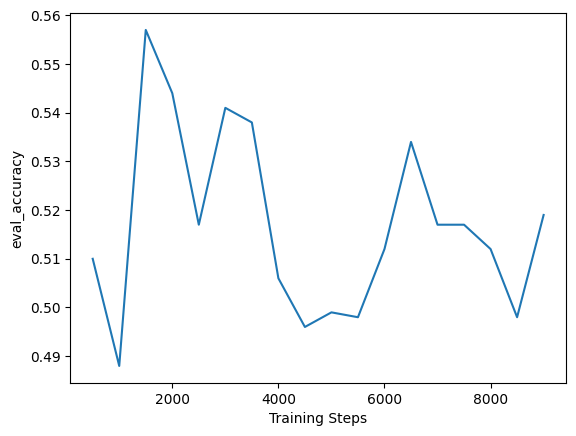

In [32]:
plot_metric("eval_accuracy") 

Finally, we'll plot the learning rate as a function of the training step.

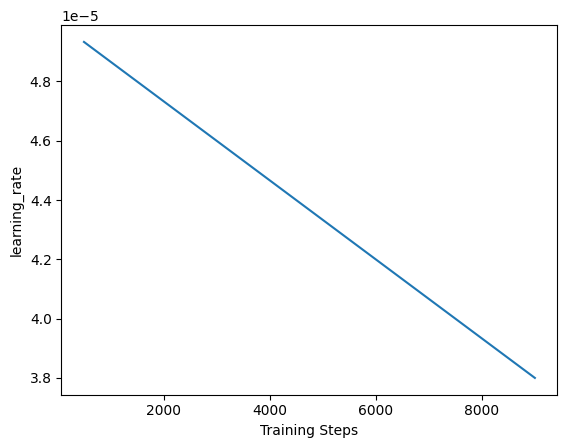

In [33]:
plt.clf()
plot_metric("learning_rate")

## Summary

This tutorial covers fine-tuning a BERT model to perform sentiment analysis from the Financial Tweet Sentiment Dataset. 

We applied the following tools in this notebook:
* We used the HuggingFace library to perform data processing, fine-tune the BERT model, and evaluate the accuracy between the predicted class and reference. 
* We benchmarked the naive BERT model and the fine-tuned BERT model, and we were able to boost performance by 17%.
* We used MLFlow for model training logging, which is a useful MLOps tool.

Follow the our blog, [The Stack](https://torchstack.ai/blogs/torchstack) for more hands-on tutorials, reviews and summaries of essential AI concepts, and what we're seeing go on in the AI space. 

You can also check out our [GitHub](https://github.com/torchstack-ai) page for more projects and code samples.  